## RBF vs Nystroem kernel approximation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
# from sklearn.decomposition import PCA
from sklearn import datasets

In [4]:
from keras.datasets import mnist
import pickle
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Define classifiers

In [16]:
# SVM classifiers
gamma = 0.01
kernel_svm = svm.SVC(kernel='rbf', gamma=gamma)
linear_svm = svm.SVC(kernel='linear')

# the two methods
random_fourier = RBFSampler(gamma=gamma, random_state=1)
nystroem = Nystroem(gamma=gamma, random_state=1)

# pipelines for kernel approxixmations
fourier_svm = pipeline.Pipeline([("feature_map", random_fourier),("svm", linear_svm)])
nystroem_svm = pipeline.Pipeline([("feature_map", nystroem),("svm", linear_svm)])

## Fitting functions

In [7]:
# fit and predict linear and kernel SVMs

def kernel(train_data, train_labels, test_data, test_labels): 
    
    print("\nkernel svm fitting")
    start = time()
    kernel_svm.fit(train_data, train_labels)
    kernel_svm_score = kernel_svm.score(test_data,test_labels)
    kernel_svm_time = time() - start
    return({'score':kernel_svm_score, 'time':kernel_svm_time})

def linear(train_data, train_labels, test_data, test_labels):
    print("\nlinear svm fitting")
    start = time()
    linear_svm.fit(train_data, train_labels)
    linear_svm_score = linear_svm.score(test_data, test_labels)
    linear_svm_time = time() - start
    return ({'score':linear_svm_score, 'time':linear_svm_time})

In [8]:
def nystroem(train_data, train_labels, test_data, test_labels):
    
    print("\nnystroem svm fitting")
    
    nystroem_scores = []
    nystroem_times = []
    sample_sizes = samples(train_data)

    for D in sample_sizes:
        print("\n", D, "/", max(sample_sizes),"samples")
        # set the number of samples
        nystroem_svm.set_params(feature_map__n_components=D)

        start = time()
        nystroem_svm.fit(train_data, train_labels)
        nystroem_times.append(time() - start)

        nystroem_score = nystroem_svm.score(test_data, test_labels)
        nystroem_scores.append(nystroem_score)
    
    return({'scores':nystroem_scores, 'times':nystroem_times})

In [9]:
def fourier(train_data, train_labels, test_data, test_labels):
    
    print("\nfourier svm fitting")

    fourier_scores = []
    fourier_times = []
    sample_sizes = samples(train_data)

    for D in sample_sizes:
        print("\n", D, "/", max(sample_sizes),"samples")
        fourier_svm.set_params(feature_map__n_components=D)

        start = time()
        fourier_svm.fit(train_data, train_labels)
        fourier_times.append(time() - start)

        fourier_score = fourier_svm.score(test_data, test_labels)
        fourier_scores.append(fourier_score)

    return({'scores':fourier_scores, 'times':fourier_times})

In [10]:
# fits all methods and predicts test set
def fit_all(train_data, train_labels, test_data, test_labels):
    
    kernel_out = kernel(train_data, train_labels, test_data, test_labels)
    linear_out = linear(train_data, train_labels, test_data, test_labels)
    nystroem_out = nystroem(train_data, train_labels, test_data, test_labels)
    fourier_out = fourier(train_data, train_labels, test_data, test_labels)
    
    return({'kernel':kernel_out, 'linear':linear_out, 'nystroem':nystroem_out, 'fourier':fourier_out})

In [11]:
def save(fit, filename):
    with open('pickle/'+filename+'.pickle', 'wb') as handle:
        pickle.dump(fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

## plot

In [12]:
# takes a fit_all argument
def plot_results(fit):
    
    kernel = fit['kernel']
    linear = fit['linear']
    nystroem = fit['nystroem']
    fourier = fit['fourier']
    
    kernel_svm_score = kernel['score']
    linear_svm_score = linear['score']
    nystroem_scores = nystroem['scores']
    fourier_scores = fourier['scores']
    
    kernel_svm_time = kernel['time']
    linear_svm_time = linear['time']
    nystroem_times = nystroem['times']
    fourier_times = fourier['times']
    
    sample_sizes = samples(train_data)
    
    # plot the results
    plt.figure(figsize=(8, 8))

    accuracy = plt.subplot(211)
    # second y axis for timings
    timescale = plt.subplot(212)

    accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
    timescale.plot(sample_sizes, nystroem_times, '--',
                   label='Nystroem approx. kernel')

    accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
    timescale.plot(sample_sizes, fourier_times, '--',
                   label='Fourier approx. kernel')

    # horizontal lines for exact rbf and linear kernels:
    accuracy.plot([sample_sizes[0], sample_sizes[-1]],
                  [linear_svm_score, linear_svm_score], label="linear svm")
    timescale.plot([sample_sizes[0], sample_sizes[-1]],
                   [linear_svm_time, linear_svm_time], '--', label='linear svm')

    accuracy.plot([sample_sizes[0], sample_sizes[-1]],
                  [kernel_svm_score, kernel_svm_score], label="rbf svm")
    timescale.plot([sample_sizes[0], sample_sizes[-1]],
                   [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

    # vertical line for dataset dimensionality = 64
    # accuracy.plot([64, 64], [0.7, 1], label="n_features")

    # legends and labels
    accuracy.set_title("Classification accuracy")
    timescale.set_title("Training times")
    accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
    # accuracy.set_xticks(())
    accuracy.set_ylim(np.min(fourier_scores), 1)
    timescale.set_xlabel("Sampling steps = transformed feature dimension")
    accuracy.set_ylabel("Classification accuracy")
    timescale.set_ylabel("Training time in seconds")
    accuracy.legend(loc='best')
    timescale.legend(loc='best')

    plt.show()

In [5]:
# number of random samples
def samples(train_data):
#     samples = len(train_data)//60 * np.arange(1,10)
    samples = 30 * np.arange(1,9)
    return(samples)

## Small MNIST

In [2]:
%run -i 'functions.py'
%run -i 'encode_csv.py'

Using TensorFlow backend.


In [3]:
# load digits dataset

digits = datasets.load_digits(n_class=9)
# digits = datasets.fetch_mldata("MNIST original")

print(digits.data.shape)
# plt.matshow(digits.images[0])
# it contains 1617 images of digits. 
# Each image is represented by an 8x8 matrix.

(1617, 64)


In [4]:
n_samples = len(digits.data)
# normalize data: here pixels have values between 0 and 16

print(digits.data[0])

data = digits.data / 16.
# each image is a row vector with 64 entries.
# we take the mean of each column, which gives 64 means (one over each component of the image)

print("\n",data[0])

mean = data.mean(axis=0)
print("\n",len(mean), "means (one over each column)")

# between -1 and 1
data -= mean

print("\n",data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]

 [0.     0.     0.3125 0.8125 0.5625 0.0625 0.     0.     0.     0.
 0.8125 0.9375 0.625  0.9375 0.3125 0.     0.     0.1875 0.9375 0.125
 0.     0.6875 0.5    0.     0.     0.25   0.75   0.     0.     0.5
 0.5    0.     0.     0.3125 0.5    0.     0.     0.5625 0.5    0.
 0.     0.25   0.6875 0.     0.0625 0.75   0.4375 0.     0.     0.125
 0.875  0.3125 0.625  0.75   0.     0.     0.     0.     0.375  0.8125
 0.625  0.     0.     0.    ]

 64 means (one over each column)

 [ 0.00000000e+00 -2.00989487e-02 -9.46969697e-03  7.27427335e-02
 -1.82127396e-01 -2.97735003e-01 -8.36811998e-02 -8.15553494e-03
 -3.86518244e-04 -1.21559988e-01  1.79537724e-01  1.72155226e-01
 -1.85142239e-02  4.48670377e-01  2.02380952e-01 -6.64811379e-0

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data, digits.target, test_size=0.30, random_state=1)

In [164]:
%run -i 'functions.py'
small_mnist_fit = fit_all(train_data, train_labels, test_data, test_labels, gamma=0.2)


using gamma= 0.2

nystroem svm fitting

 120 / 300 samples

 150 / 300 samples

 180 / 300 samples

 210 / 300 samples

 240 / 300 samples

 270 / 300 samples

 300 / 300 samples

fourier svm fitting

 120 / 300 samples

 150 / 300 samples

 180 / 300 samples

 210 / 300 samples

 240 / 300 samples

 270 / 300 samples

 300 / 300 samples

kernel svm fitting

linear svm fitting


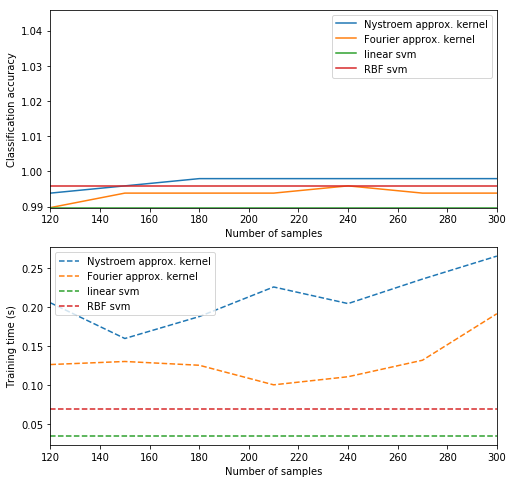

In [177]:
# prova con pickle
save(small_mnist_fit, 'small_mnist_fit')
prova = pickle.load(open('pickle/small_mnist_fit.pickle','rb'))
plot_results(prova)

Questo plot ovviamente è inutile perché ho così poche osservazione che il training lineare è più accurato dei due metodi.

Devo mostrare, su dataset abbastanza grandi, che i due metodi hanno una buona accuratezza (quasi come il kernel) e tempi di esecuzione molto più bassi (vicini alla lineare).

In [6]:

# plotly

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn import datasets

X = train_data
y = train_labels

n_components=9

start = time()
pca = PCA(n_components).fit(X)
pca_time = time() - start

X_pca = pca.transform(X)

X1, X2 = np.linspace(-0.5, 0.5, 30), np.linspace(-0.5, 0.5, 30)
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T

gamma = 0.1
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=False, gamma=gamma)
X_kpca = kpca.fit_transform(X)

fourier = RBFSampler(gamma=gamma, random_state=1)
fourier_pca = pipeline.Pipeline([("feature_map", fourier),("pca", PCA(n_components))])
start = time()
fourier_pca.fit(X)
fourier_time = time() - start
X_fourier_pca = fourier_pca.transform(X)


nystroem = Nystroem(gamma=gamma, random_state=1)
nystroem_pca = pipeline.Pipeline([("feature_map", nystroem),("pca", PCA(n_components))])
start = time()
nystroem_pca.fit(X)
nystroem_time = time() - start
X_nystroem_pca = nystroem_pca.transform(X)

## PCA projections

This function simply computes the projections

<Figure size 432x288 with 0 Axes>

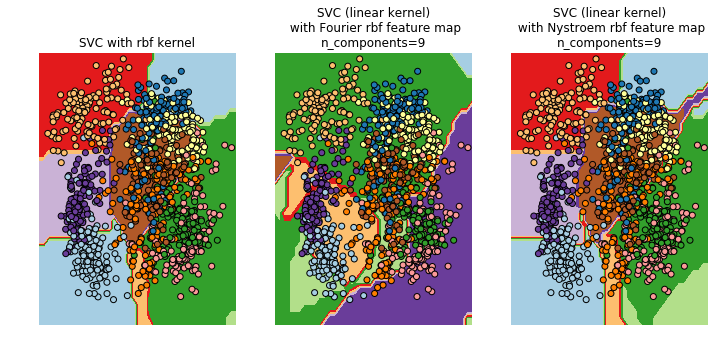

In [178]:
%run -i 'pca_projections.py'
pca_projections(train_data, train_labels, 9)

## MNIST original

Following this: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/


In [1]:
%run -i 'functions.py'
%run -i 'encode_csv.py'

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
digits = X_train

print("train:", X_train.shape, ", test:", X_test.shape)

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# print(X_train.shape)
# normalize from 0-255 to 0-1
X_train = X_train // 255
X_test = X_test // 255

# now to -1 - 1
train_mean = X_train.mean(axis=0)
test_mean = X_test.mean(axis=0)

X_train -= train_mean
X_test -= test_mean

# not taking the whole dataset
n = 1000
X_train = X_train[:n]
y_train = y_train[:n]
X_test = X_test[:n//20]
y_test = y_test[:n//20]

print("train:", X_train.shape, ", test:", X_test.shape)

train: (60000, 28, 28) , test: (10000, 28, 28)
train: (1000, 784) , test: (50, 784)


## PCA projections

In [3]:
# plotly

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn import datasets

############################################################


n = 1000
X = X_train[:n]
y = y_train[:n]


###########################################################

n_components=9

start = time()
pca = PCA(n_components).fit(X)
pca_time = time() - start
X_pca = pca.transform(X)

gamma = 0.1
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=False, gamma=gamma)
start = time()
kpca = kpca.fit(X)
kpca_time = time() - start
X_kpca = kpca.transform(X)

fourier = RBFSampler(gamma=gamma, random_state=1)
fourier_pca = pipeline.Pipeline([("feature_map", fourier),("pca", PCA(n_components))])
start = time()
fourier_pca.fit(X)
fourier_time = time() - start
X_fourier_pca = fourier_pca.transform(X)


nystroem = Nystroem(gamma=gamma, random_state=1)
nystroem_pca = pipeline.Pipeline([("feature_map", nystroem),("pca", PCA(n_components))])
start = time()
nystroem_pca.fit(X_train)
nystroem_time = time() - start
X_nystroem_pca = nystroem_pca.transform(X)

In [4]:
# # pca projections


# colors = ['red','blue','green','yellow','orange','pink', 'black','grey']

# fig = tools.make_subplots(rows=2, cols=2,
#                           subplot_titles=("PCA, time = "+str(pca_time),
#                                           "Kernel PCA, time = "+str(kpca_time),
#                                           "Fourier PCA, time = "+str(fourier_time),
#                                           "Nystroem PCA, time = "+str(nystroem_time)))

# lines = go.Contour(x=X1, 
#                    y=X2, 
# #                    z=Z_grid, 
#                showscale=False,
#                colorscale=[[0,'white'],[1, 'black']],
#                contours=dict(coloring='lines')
#               )

# pca_projections = []
# nystroem_projections = []
# fourier_projections = []
# kpca_projections = []

# for i, color in enumerate(colors):

#     pca_projection = go.Scatter3d(x=X_pca[y==i, 0], 
#                                   y=X_pca[y==i, 1],
#                                   z=X_pca[y==i, 2],
#                                  mode='markers',
#                                  showlegend=False,
#                                  marker=dict(color=color,
#                                              line=dict(color='black', width=1))
#                                 )

#     pca_projections.append(pca_projection)



    



#     # kernel pca

#     projection_kpca = go.Scatter(x=X_kpca[y==i, 0], 
#                                   y=X_kpca[y==i, 1],
#                                   mode='markers',
#                                   showlegend=False,
#                                   marker=dict(color=color,
#                                               line=dict(color='black', width=1))
#                                    )


#     fig.append_trace(projection_kpca, 2, 1)

#     fig['layout']['xaxis3'].update(title="1st principal component",
#                                    zeroline=False, showgrid=False)
#     fig['layout']['yaxis3'].update(title='2nd component',
#                                    zeroline=False, showgrid=False)


#     ## Fourier



#     projection_fourier = go.Scatter(x=X_fourier_pca[y==i, 0], 
#                                  y=X_fourier_pca[y==i, 1], 
#                                  mode='markers',
#                                  showlegend=False,
#                                  marker=dict(color=color,
#                                              line=dict(color='black', width=1)) 
#                                 )


#     fig.append_trace(projection_fourier, 1, 2)

#     fig['layout']['xaxis2'].update(title='1st principal component',
#                                    zeroline=False, showgrid=False)
#     fig['layout']['yaxis2'].update(title='2nd component',
#                                    zeroline=False, showgrid=False)


#     ## Nystroem



#     projection_nystroem = go.Scatter(x=X_nystroem_pca[y==i, 0], 
#                                  y=X_nystroem_pca[y==i, 1], 
#                                  mode='markers',
#                                  showlegend=False,
#                                  marker=dict(color=color,
#                                              line=dict(color='black', width=1)) 
#                                 )


#     fig.append_trace(projection_nystroem, 2, 2)


#     fig['layout']['xaxis4'].update(title='1st principal component',
#                                    zeroline=False, showgrid=False)
#     fig['layout']['yaxis4'].update(title='2nd component',
#                                    zeroline=False, showgrid=False)

# fig = go.Figure(data=pca_projections)
     
# py.iplot(fig)

In [58]:
# pca projections


colors = ['red','blue','green','yellow','orange','pink', 'black','grey', 'magenta']

fig = tools.make_subplots(rows=2, cols=2,
                          subplot_titles=("PCA, time = "+str(pca_time),
                                          "Kernel PCA, time = "+str(kpca_time),
                                          "Fourier PCA, time = "+str(fourier_time),
                                          "Nystroem PCA, time = "+str(nystroem_time)))

lines = go.Contour(x=X1, 
                   y=X2, 
#                    z=Z_grid, 
               showscale=False,
               colorscale=[[0,'white'],[1, 'black']],
               contours=dict(coloring='lines')
              )

pca_projections = []
nystroem_projections = []
fourier_projections = []
kpca_projections = []

for i, color in enumerate(colors):

    pca_projection = go.Scatter3d(x=X_pca[y==i, 0], 
                                  y=X_pca[y==i, 1],
                                  z=X_pca[y==i, 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color=color,
                                             line=dict(color='black', width=1))
                                )

    pca_projections.append(pca_projection)
    


#     # kernel pca

#     projection_kpca = go.Scatter3d(x=X_kpca[y==i, 0], 
#                                   y=X_kpca[y==i, 1],
#                                   mode='markers',
#                                   showlegend=False,
#                                   marker=dict(color=color,
#                                               line=dict(color='black', width=1))
#                                    )

#     kpca_projections.append(projection_kpca)

#     fig.append_trace(projection_kpca, 2, 1)



#     ## Fourier



#     projection_fourier = go.Scatter(x=X_fourier_pca[y==i, 0], 
#                                  y=X_fourier_pca[y==i, 1], 
#                                  mode='markers',
#                                  showlegend=False,
#                                  marker=dict(color=color,
#                                              line=dict(color='black', width=1)) 
#                                 )


#     fig.append_trace(projection_fourier, 1, 2)



#     ## Nystroem



#     projection_nystroem = go.Scatter(x=X_nystroem_pca[y==i, 0], 
#                                  y=X_nystroem_pca[y==i, 1], 
#                                  mode='markers',
#                                  showlegend=False,
#                                  marker=dict(color=color,
#                                              line=dict(color='black', width=1)) 
#                                 )


#     fig.append_trace(projection_nystroem, 2, 2)

# fig['layout']['xaxis2'].update(title='1st principal component',
#                                zeroline=False, showgrid=False)
# fig['layout']['yaxis2'].update(title='2nd component',
#                                zeroline=False, showgrid=False)


# fig['layout']['xaxis4'].update(title='1st principal component',
#                                zeroline=False, showgrid=False)
# fig['layout']['yaxis4'].update(title='2nd component',
#                                zeroline=False, showgrid=False)


# fig['layout']['xaxis3'].update(title="1st principal component",
#                                zeroline=False, showgrid=False)
# fig['layout']['yaxis3'].update(title='2nd component',
#                                zeroline=False, showgrid=False)

layout = go.Layout(title="PCA, time = "+str(pca_time))

fig = go.Figure(data=pca_projections, layout=layout )

    
py.iplot(fig)

/galileo/home/userexternal/gcarbone/virtualenv_2/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [6]:
X1, X2 = np.linspace(-0.5, 0.5, 30), np.linspace(-0.5, 0.5, 30)
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T

In [7]:
# pca projections


colors = ['red','blue','green','yellow','orange','pink', 'black','grey','magenta']

# fig = tools.make_subplots(rows=2, cols=2,
#                           subplot_titles=("PCA, time = "+str(pca_time),
#                                           "Kernel PCA, time = "+str(kpca_time),
#                                           "Fourier PCA, time = "+str(fourier_time),
#                                           "Nystroem PCA, time = "+str(nystroem_time)))

# lines = go.Contour(x=X1, 
#                    y=X2, 
# #                    z=Z_grid, 
#                showscale=False,
#                colorscale=[[0,'white'],[1, 'black']],
#                contours=dict(coloring='lines')
#               )

projections = []

for i, color in enumerate(colors):

    projection = go.Scatter3d(x=X_nystroem_pca[y==i, 0], 
                                  y=X_nystroem_pca[y==i, 1],
                                  z=X_nystroem_pca[y==i, 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color=color,
                                             line=dict(color='black', width=1))
                                )

    projections.append(projection)
    

layout = go.Layout(title="Nystroem, time = "+str(nystroem_time))
fig = go.Figure(data=projections, layout=layout)

    
py.iplot(fig)

/galileo/home/userexternal/gcarbone/virtualenv_2/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [62]:
# pca projections


colors = ['red','blue','green','yellow','orange','pink', 'black','grey','magenta']

fig = tools.make_subplots(rows=2, cols=2,
                          subplot_titles=("PCA, time = "+str(pca_time),
                                          "Kernel PCA, time = "+str(kpca_time),
                                          "Fourier PCA, time = "+str(fourier_time),
                                          "Nystroem PCA, time = "+str(nystroem_time)))

lines = go.Contour(x=X1, 
                   y=X2, 
#                    z=Z_grid, 
               showscale=False,
               colorscale=[[0,'white'],[1, 'black']],
               contours=dict(coloring='lines')
              )

projections = []

for i, color in enumerate(colors):

    projection = go.Scatter3d(x=X_fourier_pca[y==i, 0], 
                                  y=X_fourier_pca[y==i, 1],
                                  z=X_fourier_pca[y==i, 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color=color,
                                             line=dict(color='black', width=1))
                                )

    projections.append(projection)
    

layout = go.Layout(title="Fourier PCA, time = "+str(fourier_time))
fig = go.Figure(data=projections, layout=layout)

    
py.iplot(fig)

/galileo/home/userexternal/gcarbone/virtualenv_2/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [63]:
# pca projections


colors = ['red','blue','green','yellow','orange','pink', 'black','grey','magenta']

fig = tools.make_subplots(rows=2, cols=2,
                          subplot_titles=("PCA, time = "+str(pca_time),
                                          "Kernel PCA, time = "+str(kpca_time),
                                          "Fourier PCA, time = "+str(fourier_time),
                                          "Nystroem PCA, time = "+str(nystroem_time)))

lines = go.Contour(x=X1, 
                   y=X2, 
#                    z=Z_grid, 
               showscale=False,
               colorscale=[[0,'white'],[1, 'black']],
               contours=dict(coloring='lines')
              )

projections = []

for i, color in enumerate(colors):

    projection = go.Scatter3d(x=X_kpca[y==i, 0], 
                                  y=X_kpca[y==i, 1],
                                  z=X_kpca[y==i, 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color=color,
                                             line=dict(color='black', width=1))
                                )

    projections.append(projection)
    

layout = go.Layout(title="Kernel PCA, time = "+str(kpca_time))
fig = go.Figure(data=projections, layout=layout)

    
py.iplot(fig)

/galileo/home/userexternal/gcarbone/virtualenv_2/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]

